In [1]:
# feature extractoring and preprocessing data
import librosa
import librosa.display
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from pathlib import Path
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Reports
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
print('ok')


ok


In [2]:
sr = 16000
e_file1 = './assets/BLKFR-10-CPL_20190611_093000.pt540.mp3'
e_file2 = './assets/ORANGE-7-CAP_20190606_093000.pt623.mp3'

# 10 seconds of each file
y1,sr = librosa.load(e_file1, mono=True, sr=sr, offset=0, duration=10)
y2,sr = librosa.load(e_file2, mono=True, sr=sr, offset=0, duration=10)

In [3]:
from IPython.display import Audio, IFrame, display

display(Audio(y1,rate=sr))
display(Audio(y2,rate=sr))

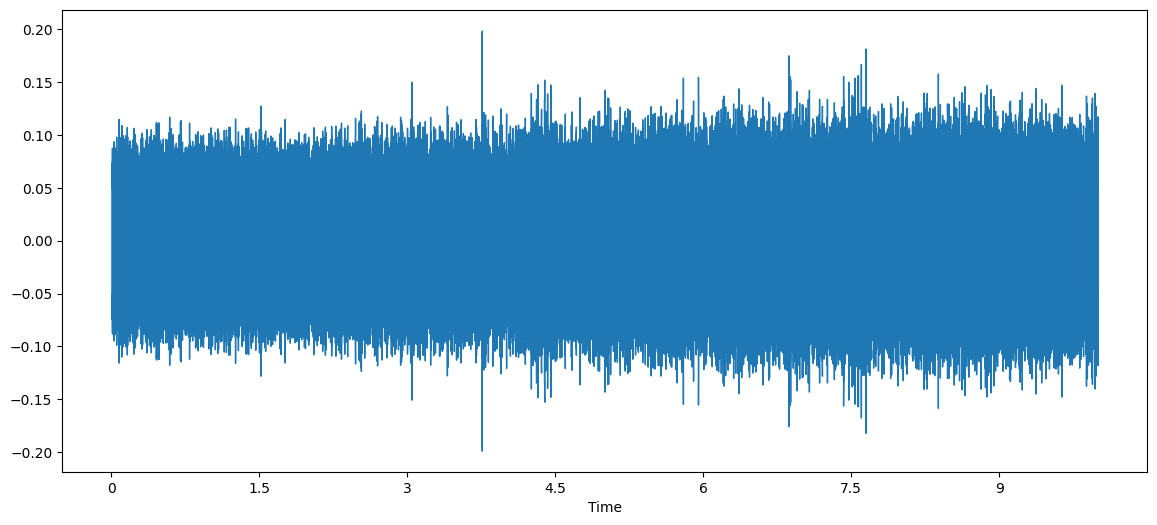

In [4]:
librosa.display.waveshow(y1, sr=sr,x_axis='time')

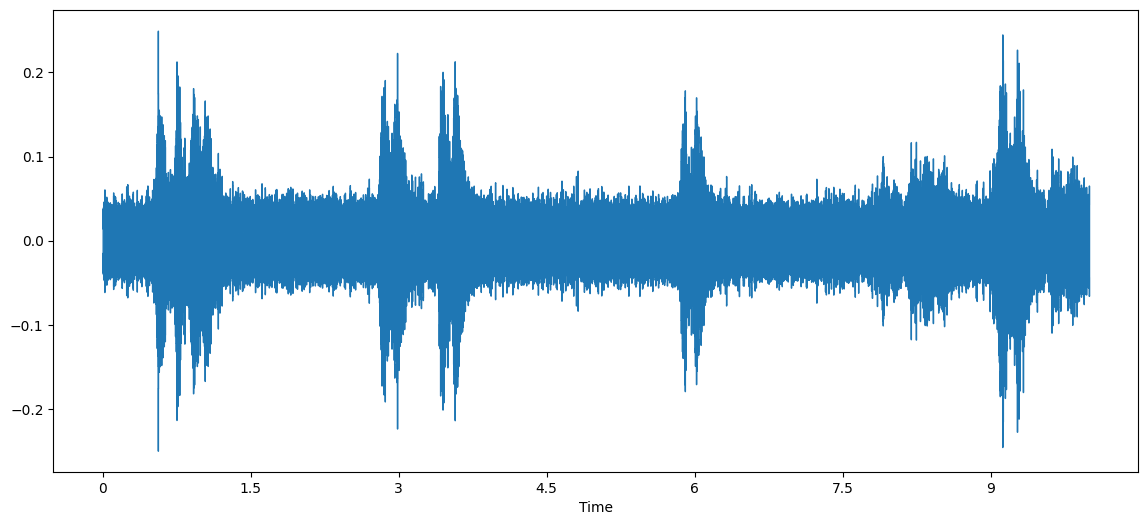

In [5]:
librosa.display.waveshow(y2, sr=sr,x_axis='time')

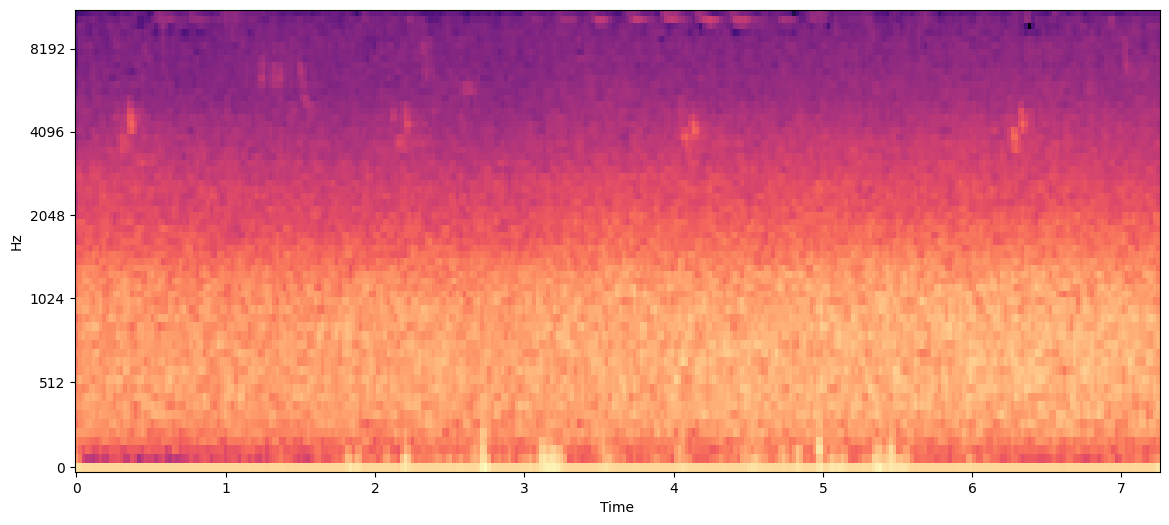

In [6]:
# Logmel-spectogram
# A very common preprocessing technique in audio detection applications is to transform audios to its log mel-spectogram representation

S1 = librosa.feature.melspectrogram(y=y1, sr=sr, n_mels=64)
D1 = librosa.power_to_db(S1, ref=np.max)
librosa.display.specshow(D1, x_axis='time', y_axis='mel');

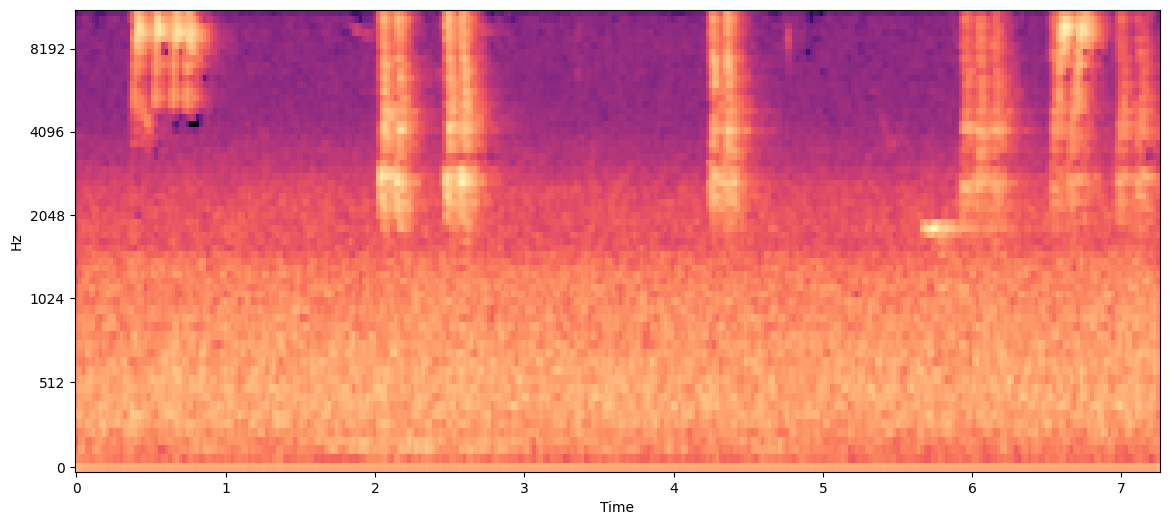

In [7]:
S2 = librosa.feature.melspectrogram(y=y2, sr=sr, n_mels=64)
D2 = librosa.power_to_db(S2, ref=np.max)
librosa.display.specshow(D2, x_axis='time', y_axis='mel');

In [8]:
# Filtering low-frequencies
# As we noticed, low frequencies does not contribute to bird sounds, a first idea is to remove these low 
# frequencies. A high pass filter helps in this task.

from scipy import signal
import random


def f_high(y,sr):
    b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
    yf = signal.lfilter(b,a,y)
    return yf

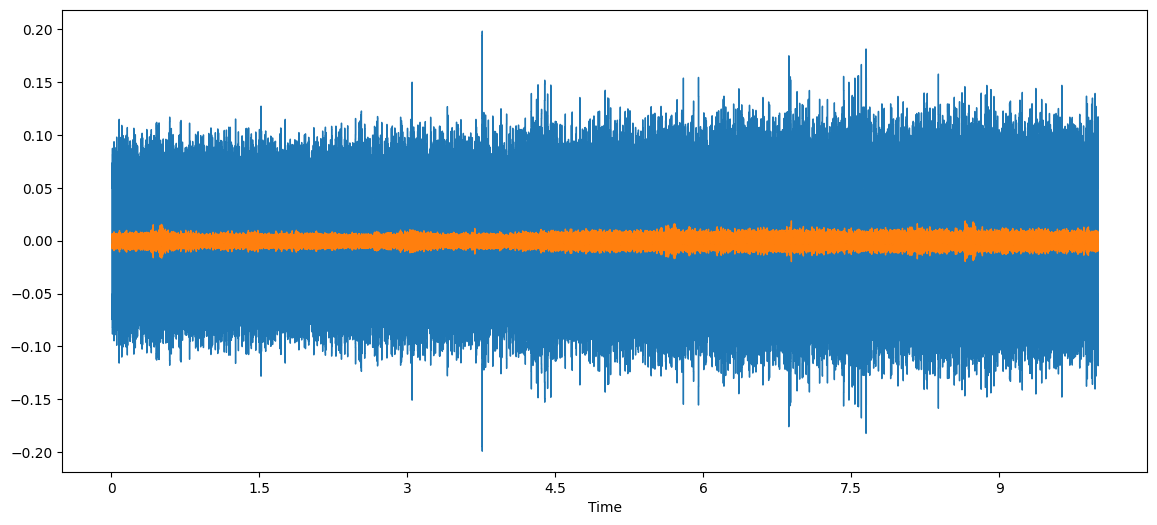

In [9]:
yf1 = f_high(y1, sr)
yf2 = f_high(y2, sr)

librosa.display.waveshow(y1, sr=sr,x_axis='time')
librosa.display.waveshow(yf1, sr=sr,x_axis='time')

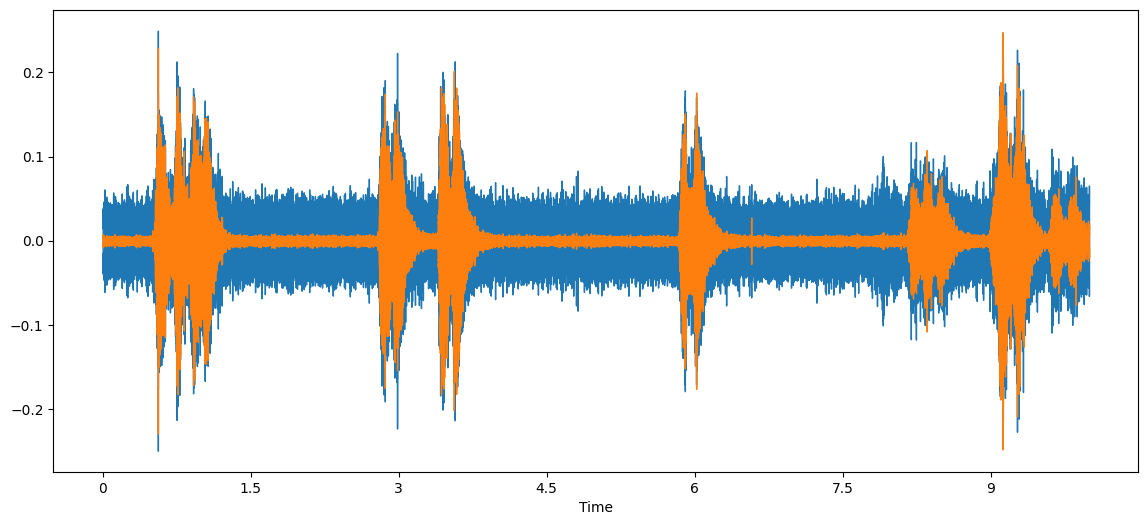

In [10]:
librosa.display.waveshow(y2, sr=sr,x_axis='time')
librosa.display.waveshow(yf2, sr=sr,x_axis='time')

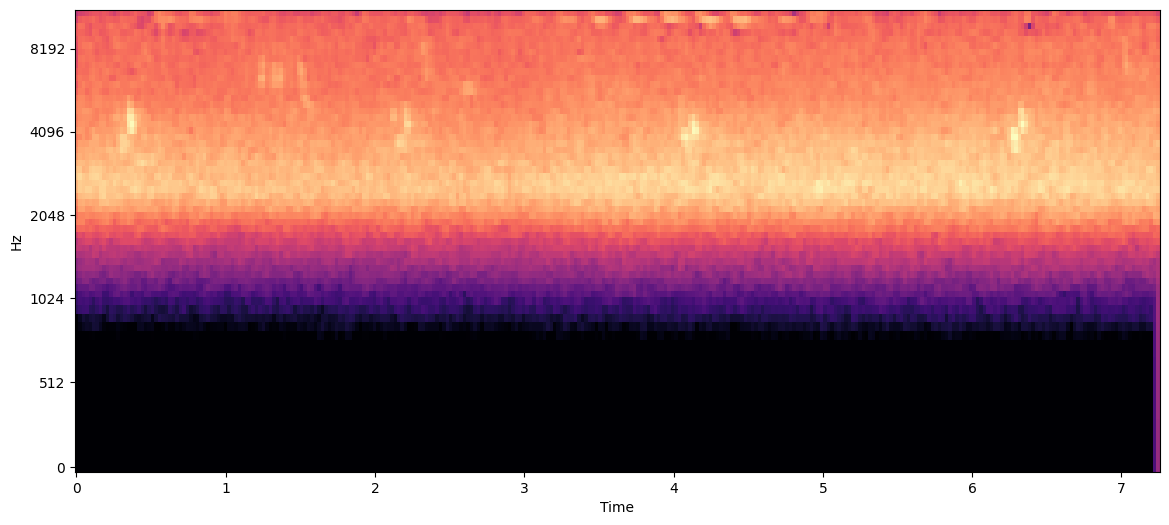

In [11]:
Sf1 = librosa.feature.melspectrogram(y=yf1, sr=sr, n_mels=64)
Df1 = librosa.power_to_db(Sf1, ref=np.max)
librosa.display.specshow(Df1, x_axis='time', y_axis='mel');

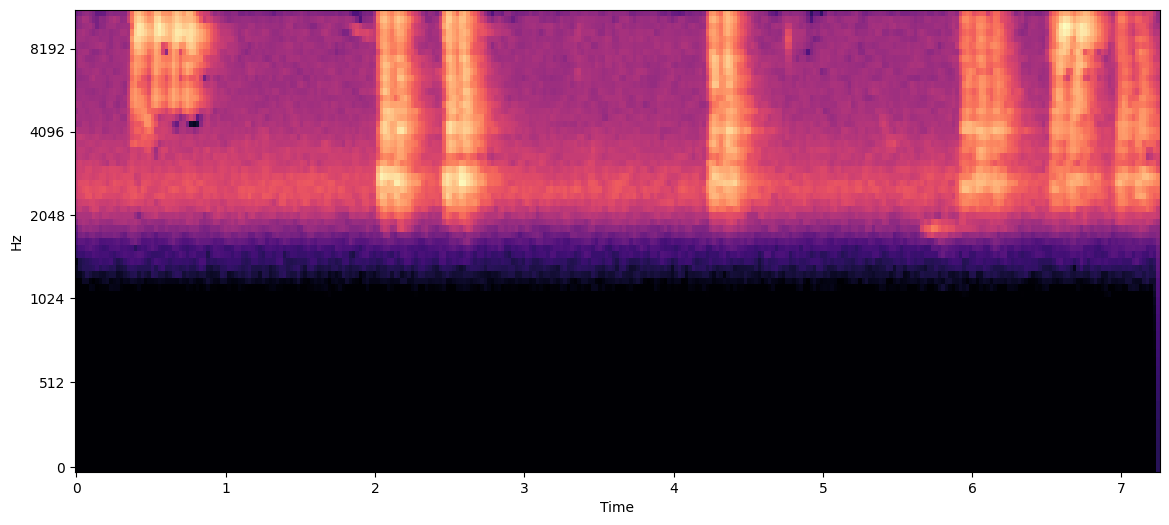

In [12]:
Sf2 = librosa.feature.melspectrogram(y=yf2, sr=sr, n_mels=64)
Df2 = librosa.power_to_db(Sf2, ref=np.max)
librosa.display.specshow(Df2, x_axis='time', y_axis='mel');

In [13]:
display(Audio(yf1,rate=sr))
display(Audio(yf2,rate=sr))

In [14]:
# PCEN
# PCEN has become a very useful strategy for acoustic event detection, and it has shown to perform better in such tasks as 
# a frontend. Its idea is to perform non-linear compression on time-frequency channels.


Dp1 = librosa.pcen(S1 * (2**31), sr=sr, gain=1.1, hop_length=512, bias=2, power=0.5, time_constant=0.8, eps=1e-06, max_size=2)
Dp2 = librosa.pcen(S2 * (2**31), sr=sr, gain=1.1, hop_length=512, bias=2, power=0.5, time_constant=0.8, eps=1e-06, max_size=2)

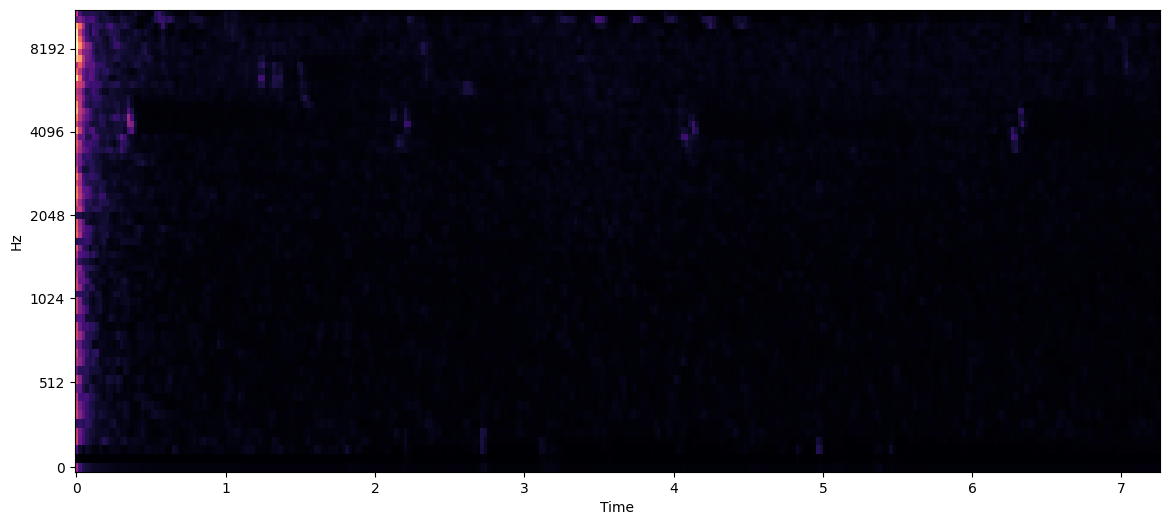

In [15]:
librosa.display.specshow(Dp1, x_axis='time', y_axis='mel')

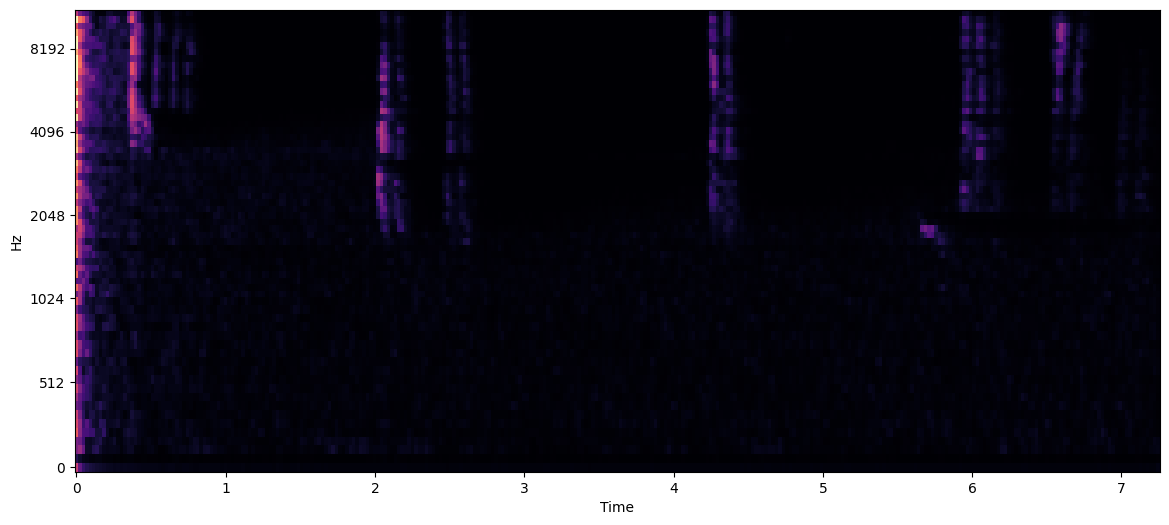

In [16]:
librosa.display.specshow(Dp2, x_axis='time', y_axis='mel');

In [17]:
yp1 = librosa.feature.inverse.mel_to_audio(Dp1)
yp2 = librosa.feature.inverse.mel_to_audio(Dp2)

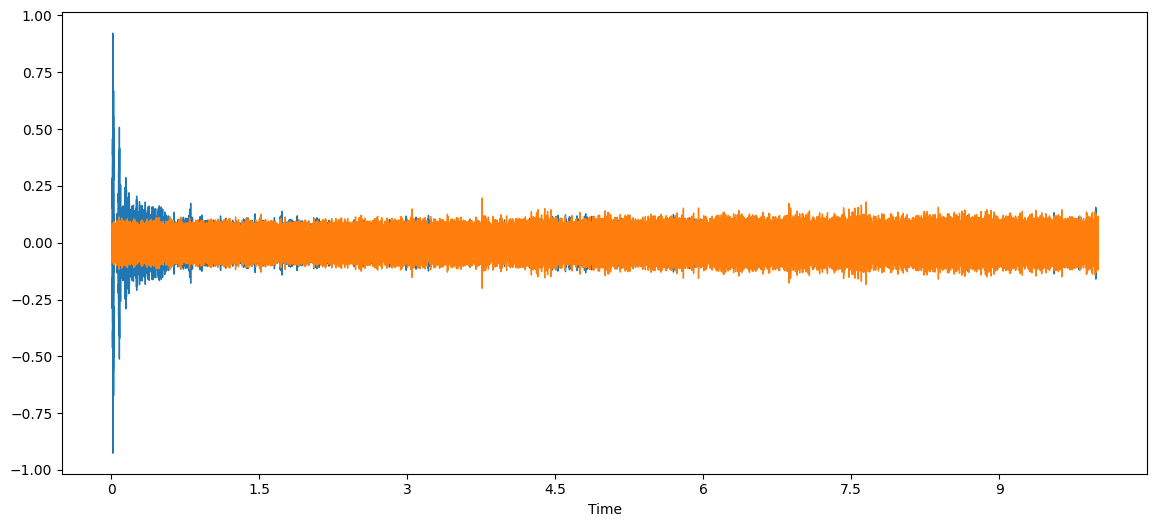

In [18]:
librosa.display.waveshow(yp1, sr=sr,x_axis='time')
librosa.display.waveshow(y1, sr=sr,x_axis='time')

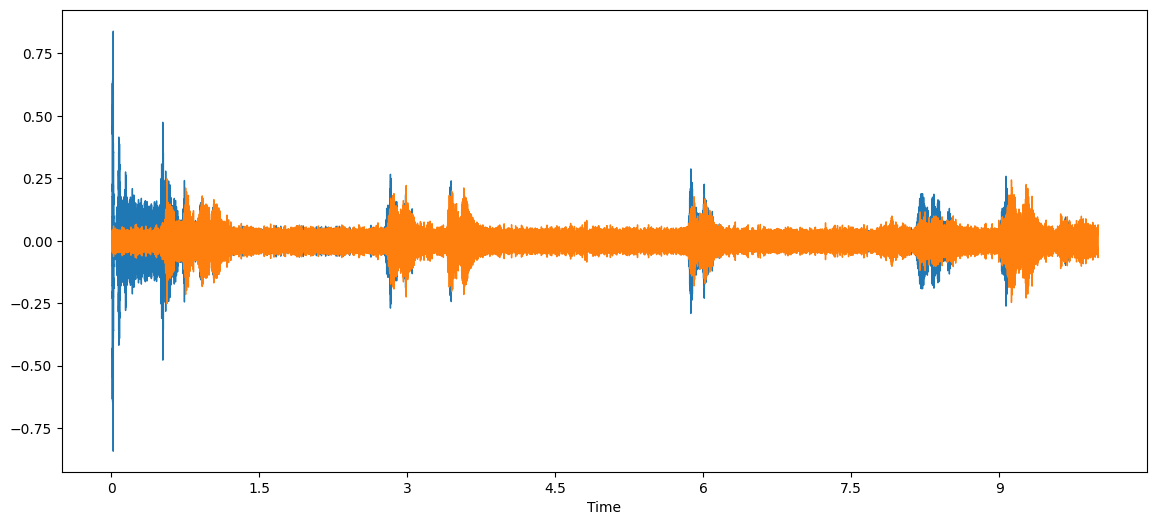

In [19]:
librosa.display.waveshow(yp2, sr=sr,x_axis='time')
librosa.display.waveshow(y2, sr=sr,x_axis='time')

In [20]:
display(Audio(yp1,rate=sr))
display(Audio(yp2,rate=sr))

In [21]:
# Spectral Gating
# This is also a technique for noise reduction based on gates that monitor audio level. It is commonly used in music 
# industry, and present in tools like Audacity


import time
from datetime import timedelta as td


def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length=hop_length, win_length=win_length)



def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()

def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    #print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal

In [22]:
noise1 = y1[5*sr:6*sr]
yg1 = removeNoise(audio_clip=y1, noise_clip=noise1,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False)
noise2 = y2[0:1*sr]
yg2 = removeNoise(audio_clip=y2, noise_clip=noise2,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=2.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False)

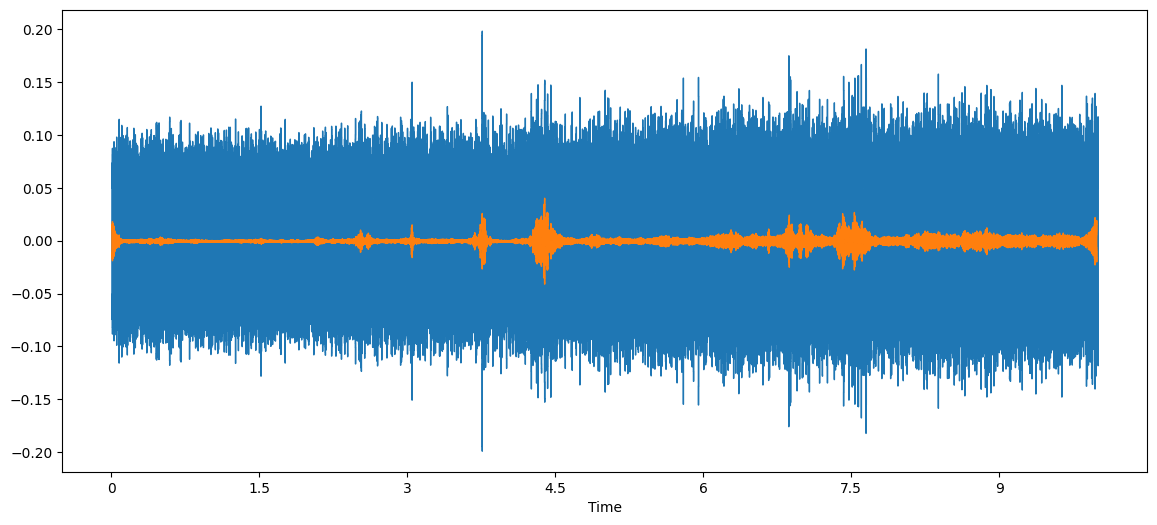

In [23]:
librosa.display.waveshow(y1, sr=sr,x_axis='time')
librosa.display.waveshow(yg1, sr=sr,x_axis='time')

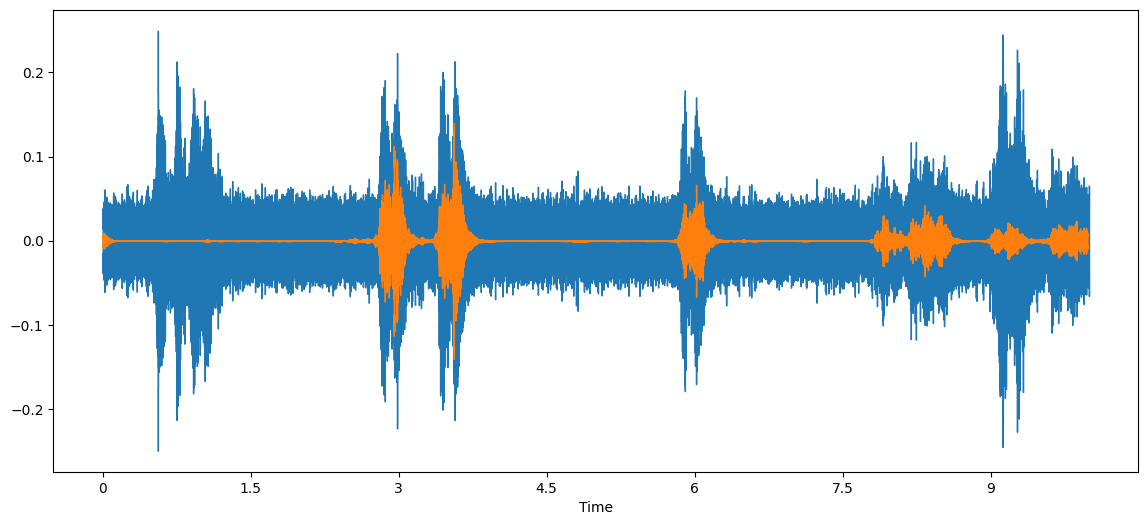

In [24]:
librosa.display.waveshow(y2, sr=sr,x_axis='time')
librosa.display.waveshow(yg2, sr=sr,x_axis='time')

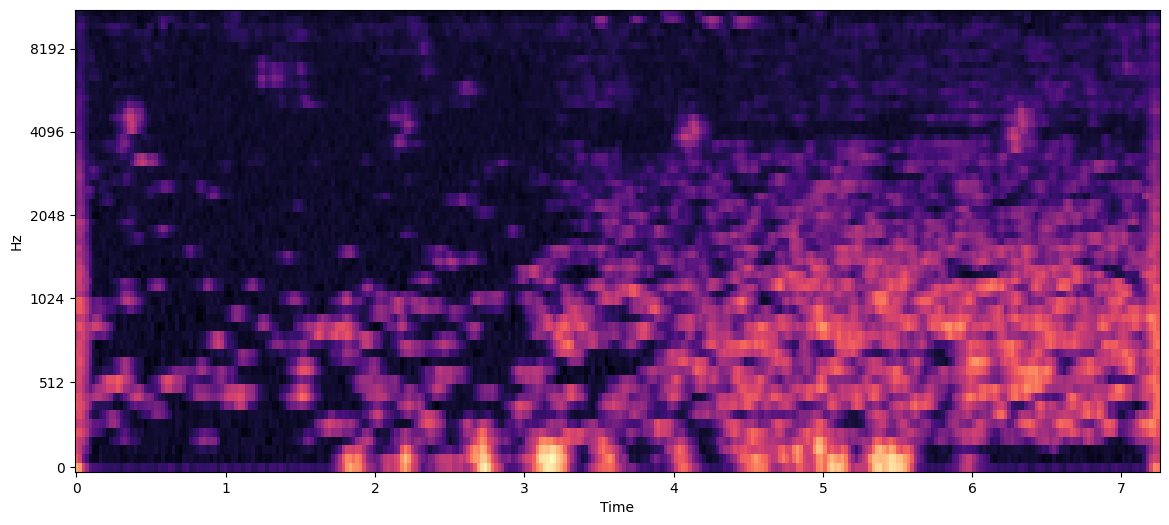

In [25]:
Sg1 = librosa.feature.melspectrogram(y=yg1, sr=sr, n_mels=64)
Dg1 = librosa.power_to_db(Sg1, ref=np.max)
librosa.display.specshow(Dg1, x_axis='time', y_axis='mel')

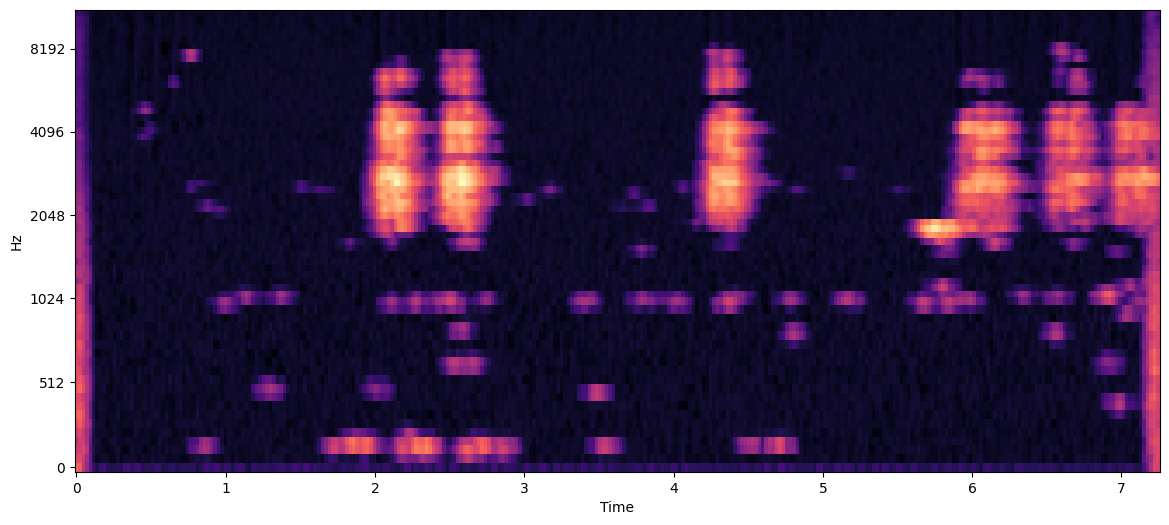

In [26]:
Sg2 = librosa.feature.melspectrogram(y=yg2, sr=sr, n_mels=64)
Dg2 = librosa.power_to_db(Sg2, ref=np.max)
librosa.display.specshow(Dg2, x_axis='time', y_axis='mel')

In [27]:
display(Audio(yg1,rate=sr))
display(Audio(yg2,rate=sr))

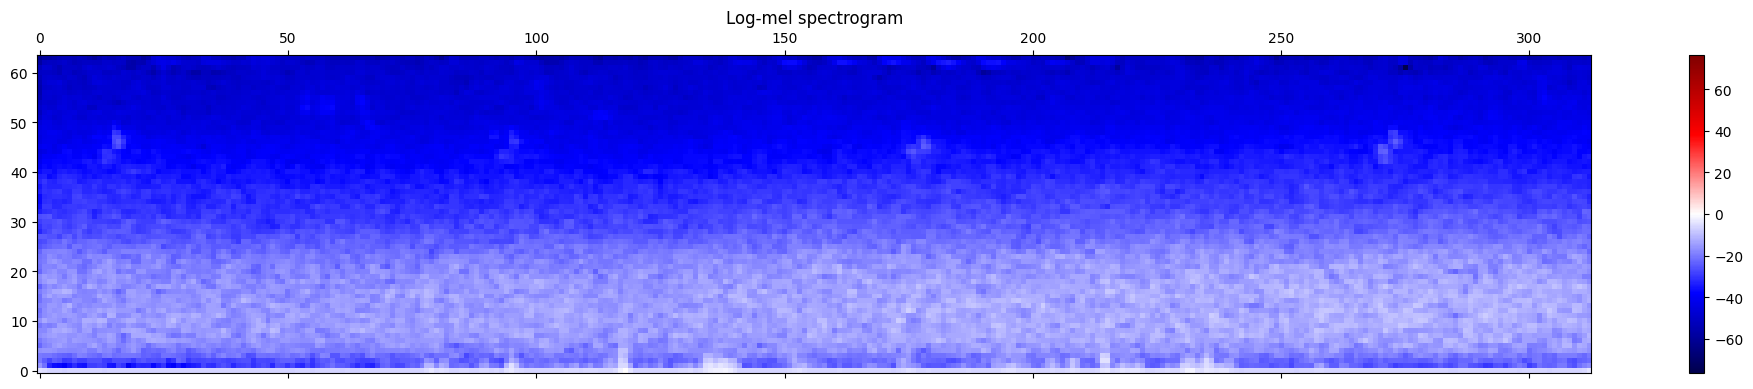

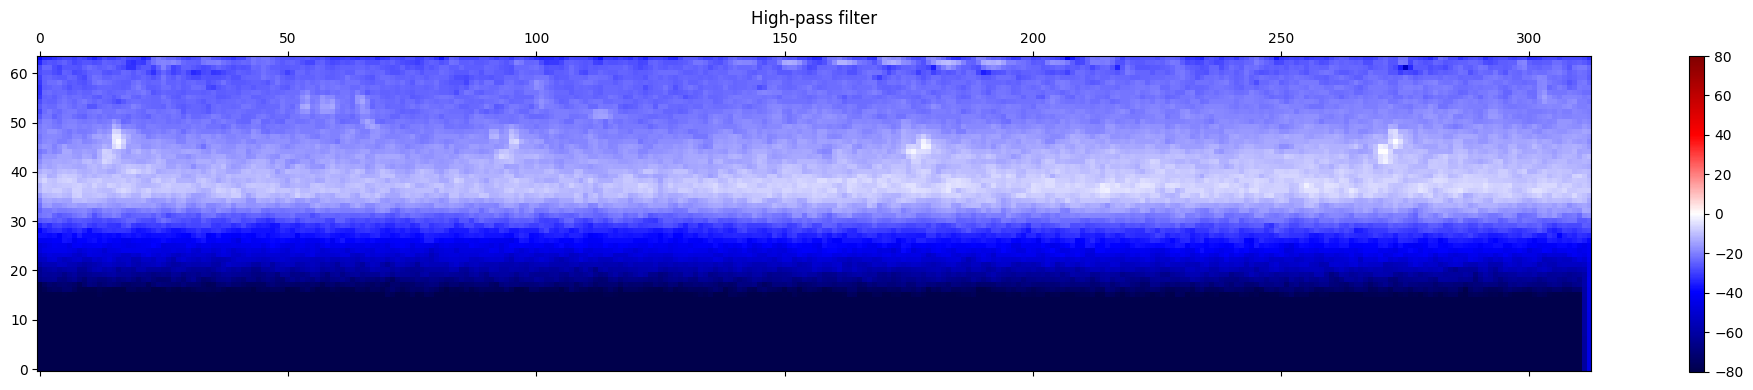

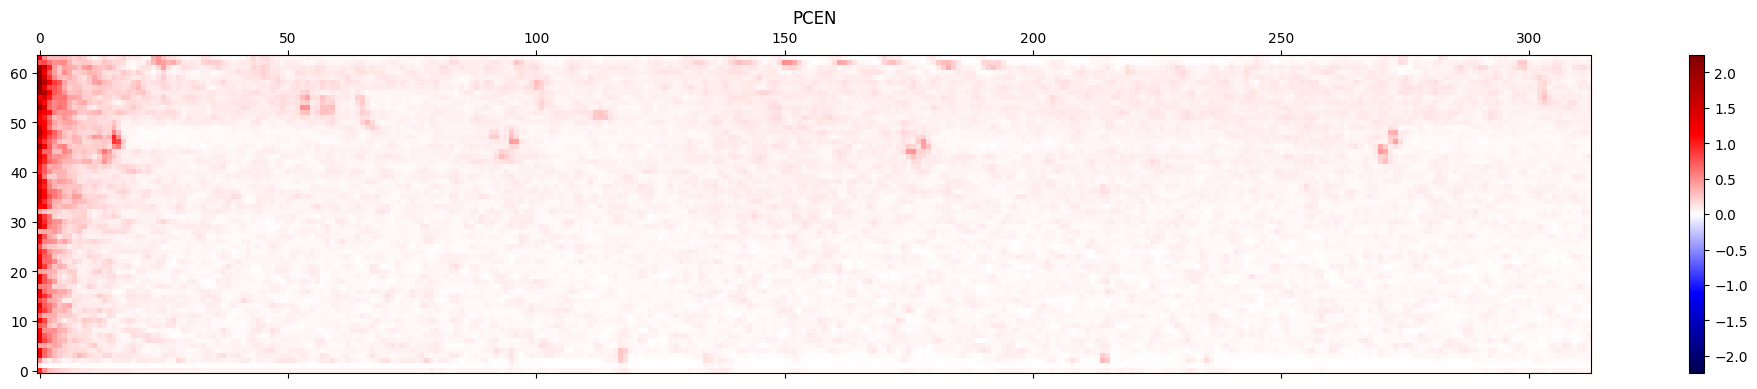

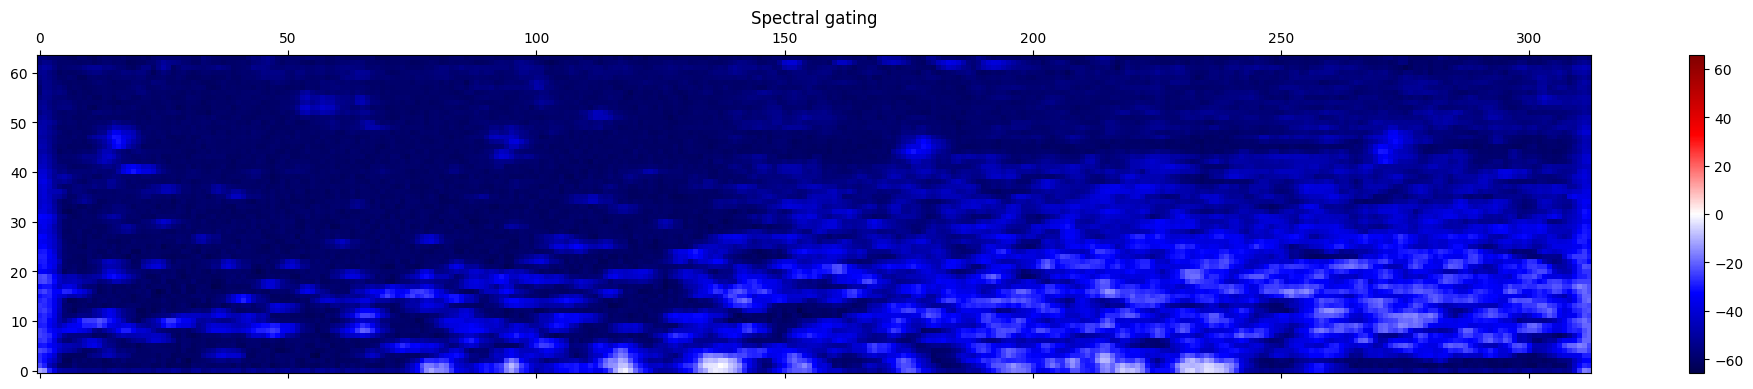

The spectrogram shows that the high-pass filter and the spectral gating techniques are the most effective in removing noise 
from the audio signal. The PCEN technique is also effective, but it does not completely remove the noise. The log-mel 
spectrogram technique is the least effective in removing noise from the audio signal.


In [34]:
# Comparison
#We can compare the different techniques using the following Spectrogram techniques:

# # 1. Log-mel spectrogram
# # 2. High-pass filter
# # 3. PCEN
# # 4. Spectral gating


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_spectrogram(D1, title='Log-mel spectrogram')
plot_spectrogram(Df1, title='High-pass filter')
plot_spectrogram(Dp1, title='PCEN')
plot_spectrogram(Dg1, title='Spectral gating')

print("The spectrogram shows that the high-pass filter and the spectral gating techniques are the most effective in removing noise \nfrom the audio signal. The PCEN technique is also effective, but it does not completely remove the noise. The log-mel \nspectrogram technique is the least effective in removing noise from the audio signal.")



In [33]:
#Conclusion
print("We have seen some techniques to preprocess audio data for bird sound detection. We have seen that log-mel spectrogram\nis a very useful representation for audio data, and that it is possible to remove noise from audio signals using\nspectral gating. We have also seen that PCEN can be used to enhance audio signals. We have also seen that high-pass\nfilters can be used to remove low frequencies from audio signals. Finally, we have seen that it is possible to remove\nnoise from audio signals using a noise clip.")


We have seen some techniques to preprocess audio data for bird sound detection. We have seen that log-mel spectrogram
is a very useful representation for audio data, and that it is possible to remove noise from audio signals using
spectral gating. We have also seen that PCEN can be used to enhance audio signals. We have also seen that high-pass
filters can be used to remove low frequencies from audio signals. Finally, we have seen that it is possible to remove
noise from audio signals using a noise clip.
